# SD212: Graph mining
## Lab 7: Graph embedding

You will learn how to embed the nodes of a graph in some low-dimensional space using the spectral decomposition of the Laplacian.

## Import

In [1]:
import networkx as nx

In [2]:
import numpy as np

In [3]:
import scipy.sparse as sp

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import matplotlib.pyplot as plt

In [6]:
%matplotlib notebook

**Hint:** To get the documentation on a `function` you can type `function?`

In [7]:
nx.to_scipy_sparse_matrix?

## Data

You will need the following datasets (the same as in previous labs, no need to download them again):
* [Les Misérables](http://perso.telecom-paristech.fr/~bonald/graphs/miserables.graphml.gz)<br>  Graph connecting the characters of the [novel of Victor Hugo](https://fr.wikisource.org/wiki/Les_Misérables) when they appear in the same chapter. The graph is undirected and weighted. Weights correspond to the number of chapters in which characters appear together. 
* [Openflights](http://perso.telecom-paristech.fr/~bonald/graphs/openflights.graphml.gz)<br>
Graph of the main international flights. Nodes are airports. The graph is undirected (all flights are bidirectional). Weights correspond to the number of daily flights between airports. Extracted from [Openflights](http://openflights.org).
* [Wikipedia for schools](http://perso.telecom-paristech.fr/~bonald/graphs/wikipedia_schools.graphml.gz)<br> Graph of the hyperlinks between a subset of the pages of the English Wikipedia. The graph is directed and unweighted.
More information [here](https://en.wikipedia.org/wiki/Wikipedia:Wikipedia_for_Schools).

## 1. Random walk

Consider an undirected graph of $n$ nodes with adjacency matrix $A$. 
Let $D = \text{diag}(w)$ be the diagonal matrix of node weights, with $w = A1$.
The transition matrix of the random walk is defined by $P = D^{-1}A$. This is a stochastic matrix.

## Toy graph

Consider the following graph:

<IPython.core.display.Javascript object>


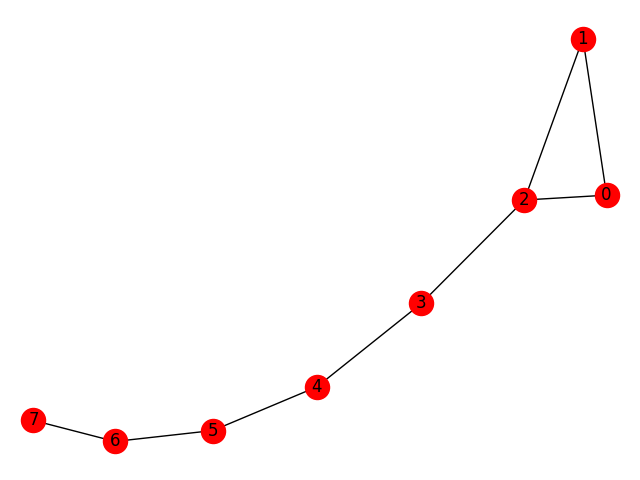

In [8]:
graph = nx.lollipop_graph(3, 5)
nx.draw(graph, with_labels = True)

In [9]:
adjacency = nx.to_scipy_sparse_matrix(graph)

In [10]:
def transition_matrix(adjacency):
    n = adjacency.shape[0]
    weights = adjacency.dot(np.ones(n))
    inverse_weight_matrix = sp.diags(1 / weights, format='csr')
    return inverse_weight_matrix.dot(adjacency)

In [11]:
P = transition_matrix(adjacency)

In [12]:
n = adjacency.shape[0]

## To do

* Complete the function `random_walk` below that compute the distribution of the random walk after `N` steps.
* Check the convergence to the stationary distribution on the above toy graph (e.g., starting from the uniform distribution).

In [52]:
def random_walk(adjacency, start, N = 10):
    '''
    adjacency: scipy CSR matrix
        adjacency matrix
    start: np array
        initial distribution (sums to 1)
    N: int
        number of steps
        
    Returns: np array
        distribution after N steps
    '''    
    distribution = start

    P_T = transition_matrix(adjacency).T
    
    for k in range(N):
        #print(np.abs((P_T.dot(distribution)) - distribution @ P_T.T.toarray()) < 1e-10)
        distribution = P_T.dot(distribution) #distribution = distribution @ P.toarray()
    
    return distribution

In [56]:
n = adjacency.shape[0]
random_walk(adjacency, np.ones(n) / n, N=100)

array([ 0.1250431 ,  0.1250431 ,  0.18730302,  0.12528696,  0.12457726,
        0.1255296 ,  0.12440736,  0.06280959])

## 2. Laplacian

The Laplacian matrix is defined by:
$$
L = D - A.
$$

In [16]:
def laplacian_matrix(adjacency):
    n = adjacency.shape[0]
    weights = adjacency.dot(np.ones(n))
    weight_matrix = sp.diags(weights, format='csr')
    return weight_matrix - adjacency

In [17]:
L = laplacian_matrix(adjacency)

In [18]:
n = adjacency.shape[0]

In [19]:
L.dot(np.ones(n))

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

## Heat equation

The Laplacian is related to a diffusion process on the graph governed by the heat equation,
$$
\forall i\not \in S, \quad  \frac{dT_i}{dt} = -(LT)_i,
$$
where $T_i$ be the temperature of node $i$ and $S$ the boundary where temperature is fixed. 

The solution satisfies:
$$
\forall i\not \in S, \quad(LT)_i = 0,
$$
or equivalently,
$$
\forall i\not \in S, \quad T_i = (PT)_i.
$$

This is the [Dirichlet problem](https://en.wikipedia.org/wiki/Dirichlet_problem).
The easiest way to compute the solution to the Dirichlet problem is to use the diffusion in discrete time:
$$
\forall i\not \in S, \quad T_i \gets (PT)_i.
$$


## To do

* Complete the `diffusion` function below that returns the temperature of each node after $N$ iterations of the  diffusion in discrete time, when the boundary set $S$ consists of two sets of nodes: the `sources` at temperature 0 and the `targets` at temperature 1. 
* Show the heat map of the above toy graph, for one source and one target of your choice. You may print the vector $LT$.
* Show the heat map of Les Miserables after the diffusion from Cosette and Fantine (sources) to Marius (target). What is the hotest node after Marius?
* Show the heat map of Openflights after the diffusion from Charles-de-Gaulle Airport (source) to Beijing Capital International Airport (target). 
* Display the 5 hotest pages of Wikipedia for Schools (considered as undirected) after diffusion from Cat to Dog. Compare with the 5 top-pages for the  Personalized PageRank associated to Dog.

In [67]:
def diffusion(adjacency, sources, targets, N = 100):
    '''
    adjacency: scipy CSR matrix
        adjacency matrix
    sources: list of int
        nodes at temperature 0
    targets: list of int
        nodes at temperature 1
    N: int
        number of steps

    Returns: np array
        temperature after N steps
    '''
    n = adjacency.shape[0]
    T = 0.5 * np.ones(n, float)
    sources = np.array(sources)
    targets = np.array(targets)
    T[sources] = 0
    T[targets] = 1

    for k in range(N):
        T = P.dot(T)
        T[sources] = 0
        T[targets] = 1

    return T

In [71]:
n = adjacency.shape[0]
T = diffusion(adjacency, [0], [n-1])

<IPython.core.display.Javascript object>


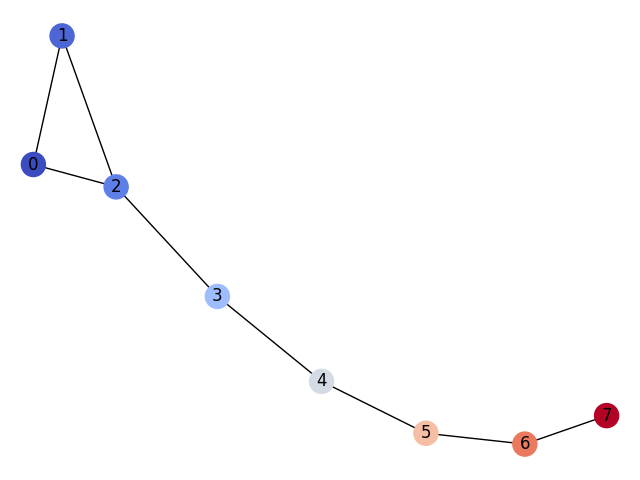

In [72]:
plt.figure()
nx.draw(graph, with_labels = True, node_color = T, cmap = 'coolwarm')

In [73]:
L = laplacian_matrix(adjacency)
print(L.dot(T))

[ -1.76470598e-01   3.58703572e-09  -3.81096199e-09   1.21979454e-08
  -6.09897266e-09   1.30639620e-08  -3.15402737e-09   1.76470582e-01]


In [ ]:
miserables = nx.read_graphml("miserables.graphml", node_type = int)
adjacency_m = nx.to_scipy_sparse_matrix(miserables)

In [ ]:
name = nx.get_node_attributes(miserables, 'name')

In [ ]:
cosette = 26
fantine = 23
marius = 55

In [ ]:
sources = [cosette, fantine]
targets = [marius]
T = diffusion(adjacency_m, sources, targets)

In [ ]:
plt.figure()
nx.draw(miserables, with_labels = True, node_color = T, cmap = 'coolwarm')

In [ ]:
i = T.argsort()[-2]
name[i]

In [ ]:
openflights = nx.read_graphml("openflights.graphml", node_type = int)
adjacency_o = nx.to_scipy_sparse_matrix(openflights)

In [ ]:
# Get positions
pos_x = nx.get_node_attributes(openflights,'pos_x')
pos_y = nx.get_node_attributes(openflights,'pos_y')
pos = {u: (pos_x[u], pos_y[u]) for u in openflights.nodes()}

In [ ]:
name = nx.get_node_attributes(openflights, 'name')

In [ ]:
cdg = 622
beijing = 1618

In [ ]:
sources = [cdg]
targets = [beijing]
T = diffusion(adjacency_o, sources, targets)

In [ ]:
plt.figure(figsize=(8,4))
nx.draw(openflights, pos, node_size = 20, node_color = T, cmap ='coolwarm')
plt.show()

In [ ]:
wikipedia = nx.read_graphml("wikipedia_schools.graphml", node_type = int).to_undirected()
adjacency_w = nx.to_scipy_sparse_matrix(wikipedia)

In [ ]:
name = nx.get_node_attributes(wikipedia, 'name')

In [ ]:
dog = 1408
cat = 2515

In [ ]:
sources = [cat]
targets = [dog]
T = diffusion(adjacency_w, sources, targets)

In [ ]:
list(map(lambda x:name[x], T.argsort()[-6:-1]))

## 3. Spectral embedding

Let $v_1,\ldots,v_n$ be the eigenvectors of the Laplacian matrix, with corresponding eigenvalues $\lambda_1= 0 < \lambda_2 \le  \ldots \le \lambda_{n}$. The spectral embedding of the graph in dimension $k$ is given by the following $n\times k$ matrix:
$$
X = \left(\frac {v_2} {\sqrt{\lambda_2}},\ldots,\frac {v_{k+1}} {\sqrt{\lambda_{k+1}}}\right)^T.
$$

In [ ]:
def spectral_decomposition_laplacian(adjacency, number = None):
    '''
    adjacency: scipy CSR matrix
        adjacency matrix
    number: int
        number of eigenvalues / eigenvectors
        
    Returns: (np array, np.array)
        eigenvalues, eigenvectors of the Laplacian matrix
    '''    
    n = adjacency.shape[0]
    if number == None or number >= n: # full spectrum
        number = n - 1
    laplacian = laplacian_matrix(adjacency)
    eigenvalues, eigenvectors = sp.linalg.eigsh(laplacian, number, sigma = -1)
    index = np.argsort(eigenvalues)
    eigenvalues = eigenvalues[index]
    eigenvectors = eigenvectors[:,index]
    return eigenvalues, eigenvectors 

## To do 

* Plot the spectrum of the Laplacian matrix associated with the toy graph, as well as the heat map of the graph associated with the Fiedler vector $v_2$
* Complete the function `spectral_embedding` below that returns the spectral embedding $X$
* Display the 2D embedding of the toy graph
* Display the 2D embedding of Les Miserables (with names)
* List the 5 closest nodes from Marius in terms of cosine similarity in the embedding of Les Miserables in dimension 10.

In [ ]:
def spectral_embedding(adjacency, k = 10):
    '''
    adjacency: scipy CSR matrix
        adjacency matrix
    k: int
        dimension of the embedding
        
    Returns: np array
        spectral embedding (based on the Laplacian)
    '''    
    n = adjacency.shape[0]
    X = np.zeros((n,k))
    # to be completed
    return X

In [ ]:
def get_cosine_similarity(X, node):
    '''
    X: np array
        embedding
    node: int
        target node
        
    Returns: np array
        cosine similarity with all other nodes
    '''        
    cosine = X.dot(X[node,:]) / np.linalg.norm(X, axis = 1) / np.linalg.norm(X[node,:])
    return cosine

## To do

* Plot the 10 first eigenvalues of the Laplacian associated with Wikipedia for Schools. What do you observe?
* List the 10 closest nodes from Dog in terms of cosine similarity in the embedding of Wikipedia for Schools in dimension 50. Redo the experiment after removing the first component of the embedding. Interpret the results.

Another spectral embedding is based on the spectral decomposition of the transition matrix. This amounts to weight each node by its weight in the graph. Let $v_1,\ldots,v_n$ be the eigenvectors of $P$, with corresponding eigenvalues $\lambda_1= 1 > \lambda_2 \ge  \ldots \ge \lambda_{n}$. The weighted spectral embedding of the graph in dimension $k$ is given by the following $n\times k$ matrix:
$$
Y = \left(\frac {v_2} {\sqrt{1-\lambda_2}},\ldots,\frac {v_{k+1}} {\sqrt{1-\lambda_{k+1}}}\right)^T.
$$

## To do

* Complete the functions `spectral_decomposition_transition` and `weighted_spectral_embedding` below. <br>
**Note:** The spectral decomposition of the transition matrix involves the normalized adjacency matrix $D^{-1/2}AD^{-1/2}$ (cf. Theorem 1 in the lecture notes).
* Do the same experiments as above for this new embedding.

In [ ]:
def spectral_decomposition_transition(adjacency, number = None):
    '''
    adjacency: scipy CSR matrix
        adjacency matrix
    number: int
        number of eigenvalues / eigenvectors
        
    Returns: (np array, np.array)
        eigenvalues, eigenvectors of the transition matrix
    '''    
    n = adjacency.shape[0]
    eigenvalues = np.zeros(k)
    eigenvectors = np.zeros((n,k))
    # to be completed
    # norm_adjacency = ...
    # eigenvalues, eigenvectors = sp.linalg.eigsh(norm_adjacency, number, which='LA')
    return eigenvalues, eigenvectors 

In [ ]:
def weighted_spectral_embedding(adjacency, k = 10):
    '''
    adjacency: scipy CSR matrix
        adjacency matrix
    k: int
        dimension of the embedding
        
    Returns: np array
        weighted spectral embedding (based on the transition matrix)
    '''    
    n = adjacency.shape[0]
    Y = np.zeros((n,k))
    # to be completed
    return Y